<h1>Sara Oppenheim, PROJECT 2!</h1>

<h2>My goal is to analyze NYPD arrest data to determine if citywide arrest rates reflect the racial composition of NYC as recorded in the 2021 US Census.</h2>  

<h3>Data sources</h3>  

**Arrest data** obtained from NYC Open Data (https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc)   

**Census data** for all of NYC obtained from the US Census Bureau (https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork/RHI225221)   


<h4>Import the packages I may need</h4>

In [6]:
import numpy as np
import pandas as pd
import scipy as sc
import sympy as sy
import matplotlib as matplot
import matplotlib.pyplot as plt
import statistics as stat
import seaborn as sns
%matplotlib inline

<h4>Convert the arrest and census data to dataframes</h4>

In [7]:
#Create a dataframe with the year-to-date arrest data. 
missing_values = ["(null)"]
arrests=pd.read_csv("nyc_arrest_ytd_uip8-fykc.csv",na_values=missing_values)

In [8]:
#Create a dataframe with the 2021 census data for NYC. 
census=pd.read_csv("Census_NYC_QuickFacts.csv")

<h4>Prepare the census data for use in my analysis</h4>

In [9]:
#Examine the census data
census.head(20)

,Fact,Fact Note,"New York city, New York","Value Note for New York city, New York"
0,"Population Estimates, July 1 2021, (V2021)",NaN,"8,467,513",NaN
1,"Population estimates base, April 1, 2020, (V2021)",NaN,"8,804,190",NaN
2,"Population, percent change - April 1, 2020 (es...",NaN,-3.80,NaN
3,"Population, Census, April 1, 2020",NaN,"8,804,190",NaN
4,"Population, Census, April 1, 2010",NaN,"8,175,133",NaN
5,"Persons under 5 years, percent",NaN,6.40,NaN
6,"Persons under 18 years, percent",NaN,20.70,NaN
7,"Persons 65 years and over, percent",NaN,14.90,NaN
8,"Female persons, percent",NaN,52.30,NaN
9,"White alone, percent",NaN,41.30,NaN


In [10]:
census.columns

Index(['Fact', 'Fact Note', 'New York city, New York',
       'Value Note for New York city, New York'],
      dtype='object')

**Only columns 1 and 3 contain useful information, I will eliminate the others.**

In [11]:
census = census[['Fact', 'New York city, New York']]


**The column headers are uninformative so I will rename them.**

In [12]:
census.rename(columns = {'Fact':'Race','New York city, New York':'Percent of NYC population'}
              ,inplace=True)


**Since I only have one data column, I want to eliminate any row with missing values.**

In [13]:
census = census.dropna()
census.head(2)


,Race,Percent of NYC population
0,"Population Estimates, July 1 2021, (V2021)","8,467,513"
1,"Population estimates base, April 1, 2020, (V2021)","8,804,190"


In [14]:
census.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63],
           dtype='int64')

**I'm only interested in the racial demographics, so I filter out the unwanted rows.
For simplicity I am only going to consider the "single race" census categories.**

In [15]:
census = census.iloc[['10','11','12','13','15','16']]


**For future operations, I want the values as numbers, not objects.**

In [16]:
census.dtypes
census = census.astype({"Percent of NYC population": float})
census.dtypes

Race                          object
Percent of NYC population    float64
dtype: object

**I eventually want to compare census data to arrest data so I am simplifying race identifiers. I will do the same thing with the arrest data.**

**This is *not okay*, but for the purposes of me being able to complete the analyses of interest I am going to merge the census data for categories "Asian alone" and "Native Hawaiian and Other Pacific Islander alone" because the arrest data only have this category: "ASIAN / PACIFIC ISLANDER" and I have no way of disentangling the two races. So I acknowledge that my conclusions regarding arrests vs. population for Asians and Pacific Islanders may be inaccurate.**

In [17]:
census['Race'].replace(['White alone, not Hispanic or Latino, percent','White alone, percent','Black or African American alone, percent','American Indian and Alaska Native alone, percent','Asian alone, percent','Native Hawaiian and Other Pacific Islander alone, percent','Hispanic or Latino, percent'],['White','White','Black','Native American','Asian OR Pacific Islander','Asian OR Pacific Islander','Hispanic'],inplace=True)
census.columns
census.head()


,Race,Percent of NYC population
10,Black,23.8
11,Native American,0.4
12,Asian OR Pacific Islander,14.3
13,Asian OR Pacific Islander,0.1
15,Hispanic,28.9


**OK, now I'm happy with the census data. On to the arrest data!**

In [18]:
#Examine the arrest data
arrests.head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,geocoded_column
0,238552639,2022-01-03T00:00:00.000,205.0,"TRESPASS 2, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 1401501,M,K,75,0,18-24,M,BLACK,1015028,185895,40.676863,-73.889037,POINT (-73.889037 40.676863)
1,238682242,2022-01-05T00:00:00.000,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 160050H,F,K,75,0,25-44,M,BLACK,1017119,183909,40.671404,-73.881509,POINT (-73.881509 40.671404)
2,238723993,2022-01-06T00:00:00.000,153.0,RAPE 3,104.0,RAPE,PL 1302503,F,K,77,0,25-44,M,WHITE,1003509,185018,40.674496,-73.930571,POINT (-73.9305713255961 40.6744956865259)
3,238821533,2022-01-08T00:00:00.000,NaN,NaN,NaN,NaN,CPL5700600,9,Q,113,3,45-64,M,WHITE HISPANIC,1046367,186986,40.679701,-73.776047,POINT (-73.77604735 40.67970059)
4,239029586,2022-01-12T00:00:00.000,NaN,NaN,NaN,NaN,CPL5700600,9,Q,113,3,25-44,M,WHITE HISPANIC,1046367,186986,40.679701,-73.776047,POINT (-73.77604735 40.67970059)


In [19]:
arrests.dtypes

arrest_key             int64
arrest_date           object
pd_cd                float64
pd_desc               object
ky_cd                float64
ofns_desc             object
law_code              object
law_cat_cd            object
arrest_boro           object
arrest_precinct        int64
jurisdiction_code      int64
age_group             object
perp_sex              object
perp_race             object
x_coord_cd             int64
y_coord_cd             int64
latitude             float64
longitude            float64
geocoded_column       object
dtype: object

In [20]:
arrests.columns

Index(['arrest_key', 'arrest_date', 'pd_cd', 'pd_desc', 'ky_cd', 'ofns_desc',
       'law_code', 'law_cat_cd', 'arrest_boro', 'arrest_precinct',
       'jurisdiction_code', 'age_group', 'perp_sex', 'perp_race', 'x_coord_cd',
       'y_coord_cd', 'latitude', 'longitude', 'geocoded_column'],
      dtype='object')

**How much missing data is there?**

In [21]:
arrests.isnull().sum()

arrest_key            0
arrest_date           0
pd_cd                15
pd_desc              21
ky_cd                21
ofns_desc            21
law_code              0
law_cat_cd           10
arrest_boro           0
arrest_precinct       0
jurisdiction_code     0
age_group             0
perp_sex              0
perp_race             0
x_coord_cd            0
y_coord_cd            0
latitude              0
longitude             0
geocoded_column       0
dtype: int64

<h4>What is in each column? Am I comfortable just dropping the columns that have missing data?</h4> 
Here I have marked in bold the columns that interest me:

**ARREST_KEY**	Randomly generated persistent ID for each arrest 

ARREST_DATE	Exact date of arrest for the reported event

PD_CD	Three digit internal classification code (more granular than Key Code)

PD_DESC	Description of internal classification corresponding with PD code (more granular than Offense Description)

KY_CD	Three digit internal classification code (more general category than PD code)

**OFNS_DESC**	Description of internal classification corresponding with KY code (more general category than PD description)

LAW_CODE	Law code charges corresponding to the NYS Penal Law, VTL and other various local laws

LAW_CAT_CD	Level of offense: felony, misdemeanor, violation 

**ARREST_BORO**	Borough of arrest. B(Bronx), S(Staten Island), K(Brooklyn), M(Manhattan), Q(Queens)

ARREST_PRECINCT	Precinct where the arrest occurred

JURISDICTION_CODE	Jurisdiction responsible for arrest. Jurisdiction codes 0(Patrol), 1(Transit) and 2(Housing) represent NYPD whilst codes 3 and more represent non NYPD jurisdictions

AGE_GROUP	Perpetrator’s age within a category

PERP_SEX	Perpetrator’s sex description

**PERP_RACE**	Perpetrator’s race description

X_COORD_CD	Midblock X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)

Y_COORD_CD	Midblock Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)

Latitude	Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) 

Longitude	Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)



**Subset the data to only include the columns of interest. Rename for clarity and elegance.**


In [22]:
arrests = arrests[["arrest_key","ofns_desc","arrest_boro","perp_race"]]
arrests.rename(columns = {'arrest_key':'unique_key','ofns_desc':'offense',
                          'arrest_boro':'borough','perp_race':'Race'},inplace=True)
arrests['borough'].replace(['K','Q','B','S','M'],['Brooklyn','Queens','Bronx','Staten Island'
                                                  ,'Manhattan'],inplace=True)
arrests.head()

,unique_key,offense,borough,Race
0,238552639,CRIMINAL TRESPASS,Brooklyn,BLACK
1,238682242,ROBBERY,Brooklyn,BLACK
2,238723993,RAPE,Brooklyn,WHITE
3,238821533,NaN,Queens,WHITE HISPANIC
4,239029586,NaN,Queens,WHITE HISPANIC


**I will use the built-in "arrest key" as my index because it contains data that is meaningful if I want to dig deeper into the specific arrest event.**


In [23]:
arrests["unique_key"].is_unique
arrests = arrests.set_index("unique_key")
arrests.head()


,offense,borough,Race
unique_key,,,
238552639,CRIMINAL TRESPASS,Brooklyn,BLACK
238682242,ROBBERY,Brooklyn,BLACK
238723993,RAPE,Brooklyn,WHITE
238821533,NaN,Queens,WHITE HISPANIC
239029586,NaN,Queens,WHITE HISPANIC


**Now how much missing data is there?**

In [24]:
arrests.isnull().sum()


offense    21
borough     0
Race        0
dtype: int64

**Since I may want to group arrests by offense, I'm dropping any rows with missing offense data.**


In [25]:
arrests=arrests.dropna()
arrests.isnull().sum()


offense    0
borough    0
Race       0
dtype: int64

**Also dropping rows where race is "unknown."**

In [26]:
arrests=arrests[arrests["Race"]!="UNKNOWN"]  
arrests["Race"].value_counts()


BLACK                             501
WHITE HISPANIC                    233
WHITE                             114
BLACK HISPANIC                     78
ASIAN / PACIFIC ISLANDER           44
AMERICAN INDIAN/ALASKAN NATIVE      5
Name: Race, dtype: int64

**I need to modify the arrest data so that the race categories match those in the census data.**

In [27]:
arrests['Race'].replace(['BLACK','WHITE HISPANIC','WHITE','BLACK HISPANIC','ASIAN / PACIFIC ISLANDER','AMERICAN INDIAN/ALASKAN NATIVE'],['Black','Hispanic','White','Hispanic','Asian OR Pacific Islander','Native American'],inplace=True)
arrests["Race"].value_counts()


Black                        501
Hispanic                     311
White                        114
Asian OR Pacific Islander     44
Native American                5
Name: Race, dtype: int64

In [28]:
arrests.info

<bound method DataFrame.info of                                    offense    borough      Race
unique_key                                                     
238552639                CRIMINAL TRESPASS   Brooklyn     Black
238682242                          ROBBERY   Brooklyn     Black
238723993                             RAPE   Brooklyn     White
239104920     ASSAULT 3 & RELATED OFFENSES   Brooklyn     Black
239623520     ASSAULT 3 & RELATED OFFENSES   Brooklyn     White
...                                    ...        ...       ...
239678172                   FELONY ASSAULT   Brooklyn     Black
239220231     ASSAULT 3 & RELATED OFFENSES   Brooklyn     White
241650053   CRIMINAL MISCHIEF & RELATED OF   Brooklyn  Hispanic
240305373     ASSAULT 3 & RELATED OFFENSES   Brooklyn  Hispanic
239457828                         BURGLARY  Manhattan  Hispanic

[975 rows x 3 columns]>

**Oops there are non-canonical missing values!**
I used "groupby" to get a list of all the missing data values I need to deal with.
For example:
arrests.groupby(["offense"]).count()
Only one non-standard value was found "(null)".
I returned to the read_csv step and added the missing value info--see above.


**There are many offenses with very low counts. I think these could skew my results or just not be interesting so I am filtering to only include offenses with >10 arrests recorded.**


In [29]:
high_arrests=arrests.groupby("offense").filter(lambda x: len(x) > 10)
high_arrests.groupby(["offense"])["borough"].count().sort_values(ascending=False)


offense
ASSAULT 3 & RELATED OFFENSES      177
PETIT LARCENY                      88
FELONY ASSAULT                     86
MISCELLANEOUS PENAL LAW            65
CRIMINAL MISCHIEF & RELATED OF     55
ROBBERY                            53
DANGEROUS DRUGS                    53
GRAND LARCENY                      42
DANGEROUS WEAPONS                  42
BURGLARY                           39
OFFENSES INVOLVING FRAUD           38
VEHICLE AND TRAFFIC LAWS           36
OFFENSES AGAINST PUBLIC ADMINI     29
OFF. AGNST PUB ORD SENSBLTY &      19
SEX CRIMES                         19
INTOXICATED & IMPAIRED DRIVING     17
FORGERY                            17
RAPE                               16
OTHER TRAFFIC INFRACTION           12
POSSESSION OF STOLEN PROPERTY      11
Name: borough, dtype: int64

**Get the all-NYC arrest count: the total number of arrest records in my data set = 914.**


In [30]:
high_arrests["offense"].count().sum()

914

**The column headers are uninformative so I will rename them.**

In [31]:
census.rename(columns = {'Fact':'Race','New York city, New York':'Percent of NYC population'},inplace=True)
#Since I only have one data column, I want to eliminate any row with missing values
census = census.dropna()
census.head(2)


,Race,Percent of NYC population
10,Black,23.8
11,Native American,0.4


**Break down the all-NYC arrest counts by race and visualize.**

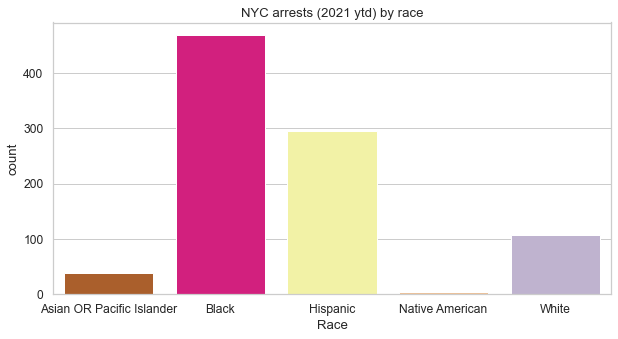

In [32]:
high_arrests.sort_values(by='Race',inplace=True)
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.title("NYC arrests (2021 ytd) by race")
a=sns.countplot(x="Race",data=high_arrests,palette="Accent_r")
plt.savefig("all-NYC arrest counts by race.png")

**Convert the arrest counts to percents.**

In [33]:
percent = pd.DataFrame(((high_arrests.groupby(['Race']).count())/914)*100)
percent = percent.rename(columns = {'offense':'percent of all NYC arrests'})
percent = percent.astype({"percent of all NYC arrests": float})
percent = pd.DataFrame(percent["percent of all NYC arrests"])
percent.describe
percent['label']=[1,2,3,4,5]
percent['Race']=["Asian OR Pacific Islander","Black","Hispanic","Native American","White"]
percent.set_index("label", inplace = True)
percent.head()


,percent of all NYC arrests,Race
label,,
1,4.157549,Asian OR Pacific Islander
2,51.203501,Black
3,32.275711,Hispanic
4,0.547046,Native American
5,11.816193,White


**Visualize the NYC arrests by percent per race.**

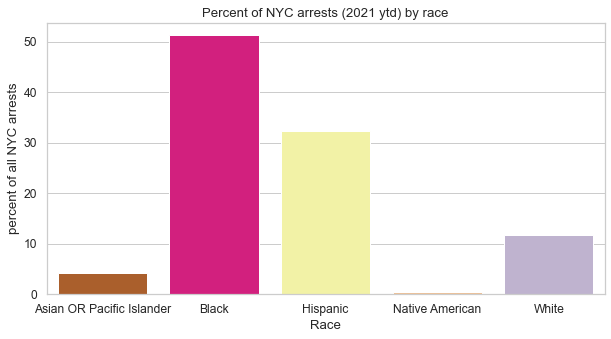

In [34]:
percent.sort_values(by='Race',inplace=True)
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.title("Percent of NYC arrests (2021 ytd) by race")
b=sns.barplot(y="percent of all NYC arrests",x="Race",data=percent,palette="Accent_r")
plt.savefig("all-NYC arrest percents by race.png")

**Visualize the census data: what percent of the NYC population does each race represent?**

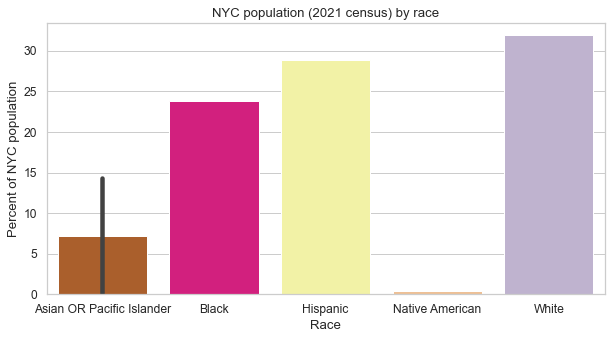

In [35]:
census.sort_values(by='Race',inplace=True)
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.title("NYC population (2021 census) by race")
c=sns.barplot(y="Percent of NYC population",x="Race",data=census,palette="Accent_r")
plt.savefig("all-NYC census population by race.png")

<h3>Now I can ask the question I was trying to get at: do the rates of arrest for each race reflect its abundance in NYC? In other words, is the arrest rate constant across races so that if race X makes up 50% of the population, they will experience ~50% of all arrests?</h4>

**Merge the census and arrest data so I can plot them together.**

In [36]:
merged=percent.merge(census, left_on='Race', right_on='Race')
merged = merged.iloc[['0','2','3','4','5']]
merged.columns
merged.head(10)

,percent of all NYC arrests,Race,Percent of NYC population
0,4.157549,Asian OR Pacific Islander,14.3
2,51.203501,Black,23.8
3,32.275711,Hispanic,28.9
4,0.547046,Native American,0.4
5,11.816193,White,31.9


**Visualize the combined data.**

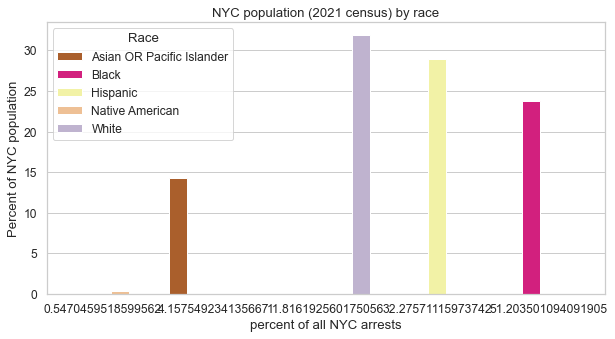

In [37]:
merged.sort_values(by='Race',inplace=True)
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.title("NYC population (2021 census) by race")
c=sns.barplot(y="Percent of NYC population",x="percent of all NYC arrests",
              data=merged,hue="Race",palette="Accent_r")


**That was not a useful visualization.**

**I am interested in the question "can arrest rates be explained by population level?" in other words does knowing population make it possible to predict arrest rates. This is a regression question so I will try a regression plot.**

<AxesSubplot:xlabel='percent of all NYC arrests', ylabel='Percent of NYC population'>

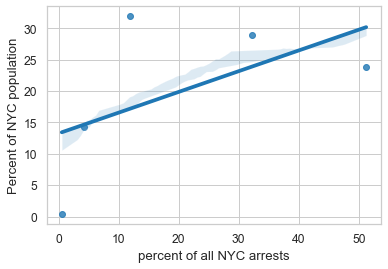

In [761]:
sns.regplot(y="Percent of NYC population", 
            x="percent of all NYC arrests", data=merged, ci=10, fit_reg="True")


**Although that worked, I couldn't find a way to color the points by race. So now I will try "lmplot" which seems to have more customization options.**

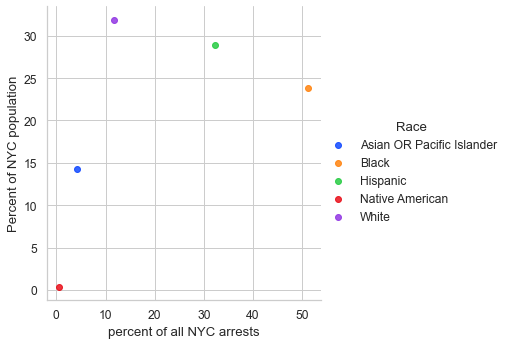

In [43]:
sns.lmplot(y="Percent of NYC population", x="percent of all NYC arrests", 
           palette="bright",data=merged, hue="Race",
          fit_reg=True, n_boot=10000, robust=True)    


<h2>Conclusions</h2>

I compared population data for NYC (as reported by the 2021 US Census) to NYPD arrest data for 2022 (arrest data covered January 1, 2022 through June 27, 2022.

Only the Hispanic race (which in the NYPD data was split into "Black Hispanic" and "White Hispanic", and in the census data was categorized as "Hispanic or Latino") had arrests approximately in keeping with their population level: Hispanics make up 28.9% of the NYC population and experienced 32.3% of all arrests. 

Asians were "under-arrested," making up 14.3% of the population but experiencing 4.2% of all arrests. Whites were similarly under-represented in arrests: they make up 41.3% of the NYC population but experienced only 11.8% of all arrests.

So who accounts for those missing arrests that Asians and Whites did not experience? Blacks make up 23.8% of NYC's population, but experienced 51% of all arrests.

Without exploring the data in more detail, it's hard to say exactly what's happening but it doesn't look very fair. I hope to examine these data further to see if 1) these patterns are statistically meaningful, 2) are these patterns the same across offense types? Across boroughs? And 3) whether arrest locations are in any way informative (for example are most arrests in low-income neighborhoods? If yes, is the population of Black people higher there?). 


<h3>The post-game analysis</h3>
**What I was trying to do**
I wanted to have columns for "arrested race is X% of NYC" "arrested race is X% of all NYC arrests" "arrested race is X% of this borough's arrests" "arrested race per offense is X% of all NYC arrests for offense" etc.--basically a much more fine-grained exploration of the relationship between race, population, and arrest rates. 

**My preliminary thoughts on accomplishing this**
#"arrested race is X% of NYC" is the census data
#"arrested race is X% of all NYC arrests" is (sum of NYC arrests for race X)/(sum of all NYC arrests)
#"arrested race is X% of this borough's arrests" is (sum of borough arrests for race X)/(sum of all borough arrests)

I need to calculate:
Total arrests in NYC, and sum for each race
Total arrests in each borough, and sum for each race
How these relate to citywide census data for race

I created this exploratory visualization but that's as far as I got with the by borough, by offense breakdown.

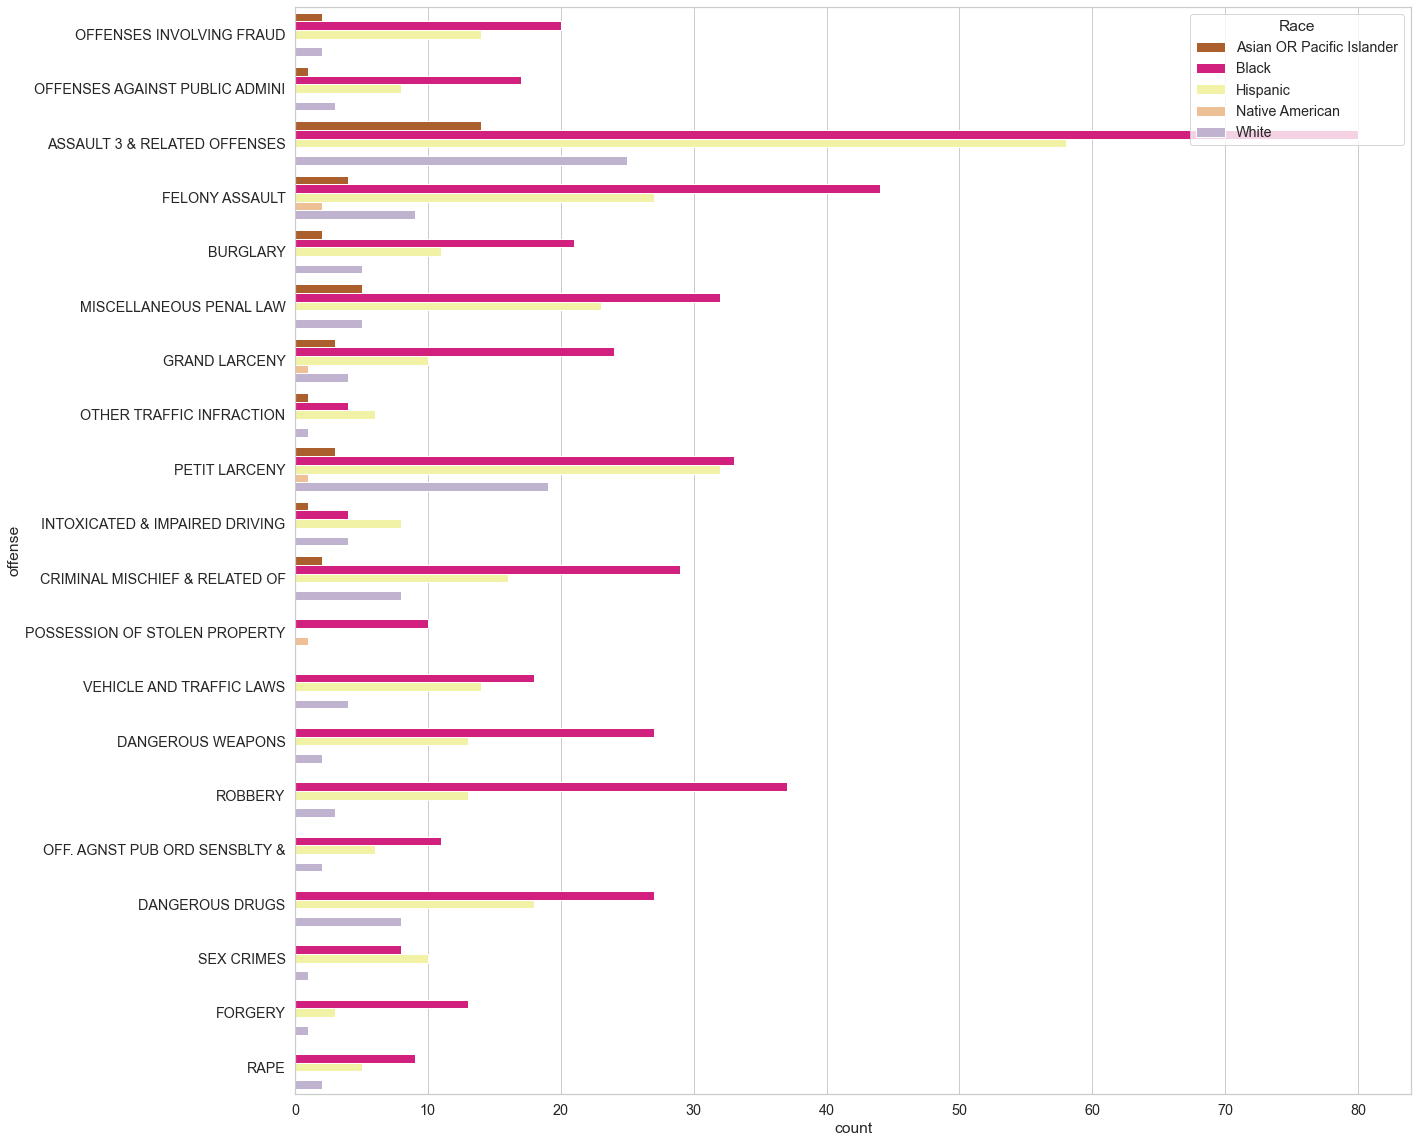

In [729]:
#all-NYC arrest counts by race and offense
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
plt.figure(figsize=(20,20))
d=sns.countplot(y="offense",hue="Race",data=high_arrests,palette="Accent_r")